In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
def get_dt(domain):
    '''
    Get the average distance between values in an ordered list.
    
    ARGUMENT: domain -- list of equally-spaced values
    RETURN: dx -- spacing between points in the domain list
    '''
    dt = (domain[-1] - domain[0]) / len(domain)
    return dt

def integrate(fn_list, dx, intercept=0):
    '''
    Numerically integrate a function (represented by a list of values 
    evaluating that function over a domain) using a Riemannian sum. 
    Use the initial condition that the function first crosses the 
    vertical axis at a value set by the "intercept".
    
    ARGUMENTS:
    fn_list -- list of values evaluating a function over a domain
    dx -- spacing between domain values
    intercept -- intercept of the integrated function with the vertical axis
    
    RETURNS:
    integral -- array of values evaluating the integral over the domain
    '''
    array = np.array(fn_list) * dx
    integral = [array[0]]
    for val in array[1:]:
        integral.append(integral[-1] + val)
    integral += intercept * np.ones(len(integral))
    return integral

def n_integ(fn_list, dx, n, get_all=False):
    '''
    Perform the integration function n times with the default initial
    conditions.
    
    ARGUMENTS:
    fn_list -- list of values evaluating a function over a domain
    dx -- spacing between domain values
    n -- number of times to perform the integration
    get_all -- boolean; specify whether to return all integrals (or just final)
    
    RETURNS:
    integ_dict -- if get_all; dictionary {1: [], ... , n: []} of integral arrays
    integ_dict[n] -- if not get_all; array of values from final integration
    
    '''
    integ_dict = {}
    integ_dict[1] = integrate(fn_list, dx)
    for k in range(1, n):
        integ_dict[k + 1] = integrate(integ_dict[k], dx)
    if get_all:
        return integ_dict
    else:
        return integ_dict[n]

In [44]:
### --------- Theoretical Equations of Motion --------- ###
'''

alpha: angular acceleration of rod (= F*s/I = 3*F/(m*s))
    F: magnitude of force constantly applied to rod
    s: 1/2 * (length of rod)
    I: moment of inertia about center of rod (= m * s^2 / 3)
    m: mass of rod

      theta(t) = 1/2 * alpha * t^2
    m * a_x(t) = -F * sin(theta(t))
    m * a_y(t) =  F * cos(theta(t))
   
'''
### ------------- Numerical coefficients  ------------- ###

def set_params(s, m, F, I=False):

    s = 1              # distance from center to edge of rod
    m = 1              # mass of rod 
    F = 1              # force on rod

    if I:
        I = I
    else:
        I = (1/3)*m*s**2   # moment of inertia of rod about its center

    A = F*s/(2*I)      # --> A = 1/2 * alpha
    B = F/m            # --> B = F/m

    '''
    Changing s, m, and F all appear only to change the SCALE of the
    plot, not the SHAPE. The shape appears to depend entirely on
    the moment of inertia I of the rotating object.
    '''
    
    return s, A, B

def calculate_eom():

    ### ---------- Numerical Equations of Motion ---------- ###

    # Computation domain
    t = np.linspace(0, 10, 10000)
    dt = get_dt(t)

    # Angular orientation of rod 
    theta = A * t ** 2   

    # Acceleration of rod COM
    a_x = -B * np.sin(theta)
    a_y = B * np.cos(theta)

    # Velocity of rod COM
    v_x = integrate(a_x, dt)
    v_y = integrate(a_y, dt)

    # Position of rod COM
    x = integrate(v_x, dt)
    y = integrate(v_y, dt)

    # Speed of rod COM
    v = (np.array(v_x) ** 2 + np.array(v_y) ** 2) ** 0.5

    # Position of rod end relative to COM
    x_rot = s * np.cos(theta)
    y_rot = s * np.sin(theta)

    # Position of rod end relative to initial frame of no motion
    x_edge_1 = x + x_rot
    y_edge_1 = y + y_rot
    x_edge_2 = x - x_rot
    y_edge_2 = y - y_rot

    # Speed of rod end relative to COM
    v_rot = 2 * A * t

    # Velocity of rod ends relative to COM
    v_x_rot_1 = -v_rot * np.sin(theta)
    v_y_rot_1 = v_rot * np.cos(theta)
    v_x_rot_2 = v_rot * np.sin(theta)
    v_y_rot_2 = -v_rot * np.cos(theta)

    # Velocity of rod ends relative to initial frame of no motion
    v_x_edge_1 = v_x + v_x_rot_1
    v_y_edge_1 = v_y + v_y_rot_1
    v_x_edge_2 = v_x + v_x_rot_2
    v_y_edge_2 = v_y + v_y_rot_2

    # Speed of rod ends relative to initial frame of no motion
    v_edge_1 = (v_x_edge_1 ** 2 + v_y_edge_1 ** 2) ** 0.5
    v_edge_2 = (v_x_edge_2 ** 2 + v_y_edge_2 ** 2) ** 0.5

    return t, v, v_x, v_y, v_edge_1, v_edge_2, x, y, x_edge_1, y_edge_1, y_edge_2, x_edge_2, y_edge_2

### ---------------------- Plots ---------------------- ###

def make_plot(fn_list, x_lab, y_lab, title, square=False):
    '''
    Make a nicely formatted x-y plot of an arbitary number of functions.

    ARGUMENTS: 
    fn_list -- list of list of [x, y] pairs of arrays
    x_lab -- label of x-axis
    y_lab -- label of y-axis
    title -- plot title
    square -- if True, make grid spacing the same in each dimension
    '''
    font = {'family': 'Century Gothic', 'weight': 'normal', 'size' : 14}
    plt.rc('font', **font)
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    if square:
        plt.axis('equal')
    ax.grid(True)
    ax.set_title(title, fontdict = {'fontsize': 24, 'weight': 'bold'})
    ax.set_xlabel(x_lab, fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_ylabel(y_lab, fontdict = {'fontsize': 16, 'weight': 'bold'})

    for item in fn_list:
        plt.plot(item[0], item[1], alpha = .9)

    plt.show()

def diagnostic_plots():

    make_plot([[t, v]], 'Time', 'COM Speed', 'COM Speed vs. Time')
    make_plot([[t, v_edge_1]], 'Time', 'Rod Edge Speed', 'Rod Edge Speed vs. Time')
    make_plot([[v_x, v_y]], r'$\mathbf{v_x}$', r'$\mathbf{v_y}$', 'COM Velocity (Euler Spiral)', square = True)
    make_plot([[x, y], [x_edge_1, y_edge_1], [x_edge_2, y_edge_2]], 'X', 'Y', 'Rod Position', square = True)

##### ----- Speed-Mapped Color Plot ----- #####

def speed_color_plot():

    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    plt.axis('equal')
    ax.grid(True)
    plt.scatter(x, y, s = 1, c = v, cmap = 'jet')
    plt.scatter(x_edge_1, y_edge_1, s = 0.05, c = v_edge_1, cmap = 'jet')
    plt.scatter(x_edge_2, y_edge_2, s = 0.05, c = v_edge_2, cmap = 'jet')
    ax.set_title('Speed-Mapped Color Plot', fontdict = {'fontsize': 24, 'weight': 'bold'})
    ax.set_xlabel('X', fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_ylabel('Y', fontdict = {'fontsize': 16, 'weight': 'bold'})
    plt.show()

##### ------- Time-mapped Color Plot ------- #####

def time_color_plot():
    
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1, 1, 1)
    plt.axis('equal')
    ax.grid(True)
    plt.scatter(x, y, s = 1, c = t, cmap = 'prism')
    plt.scatter(x_edge_1, y_edge_1, s = 0.05, c = t, cmap = 'prism')
    plt.scatter(x_edge_2, y_edge_2, s = 0.05, c = t, cmap = 'prism')
    ax.set_title('Time-Mapped Color Plot', fontdict = {'fontsize': 24, 'weight': 'bold'})
    ax.set_xlabel('X', fontdict = {'fontsize': 16, 'weight': 'bold'})
    ax.set_ylabel('Y', fontdict = {'fontsize': 16, 'weight': 'bold'})
    plt.show()

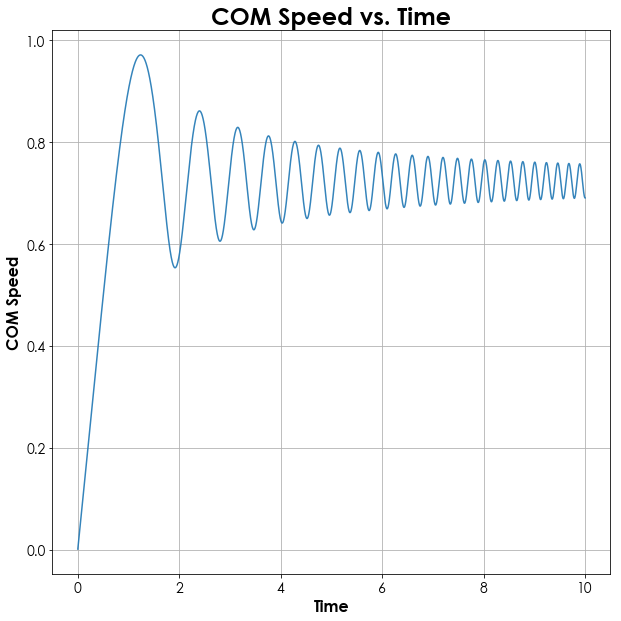

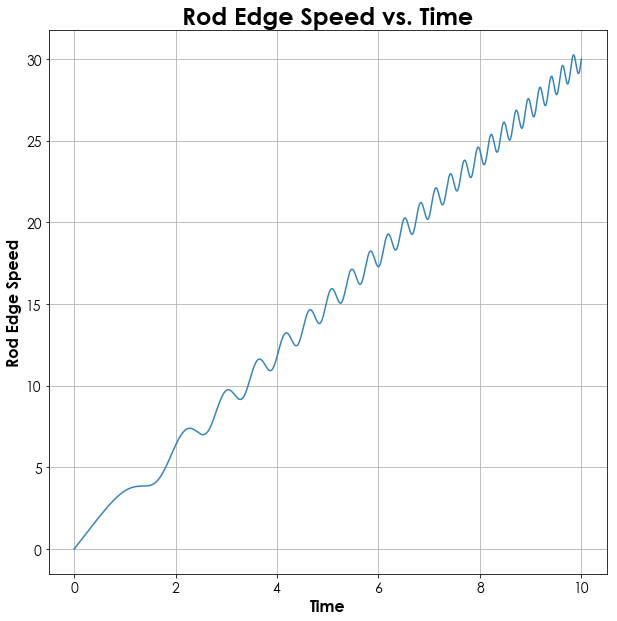

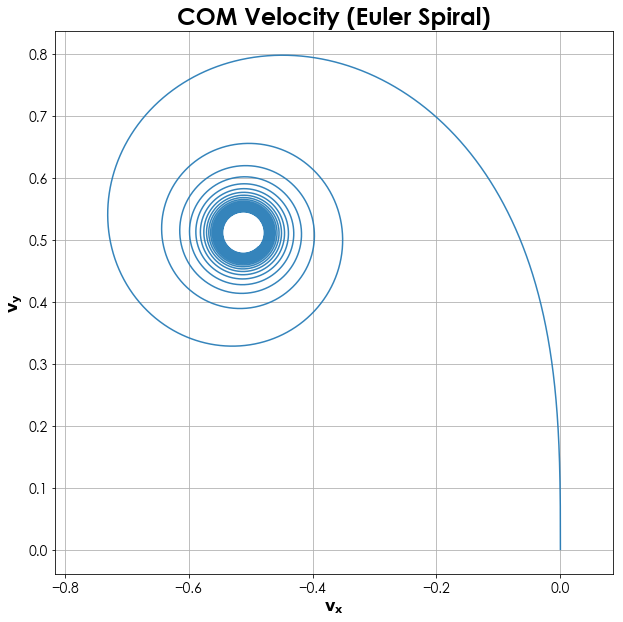

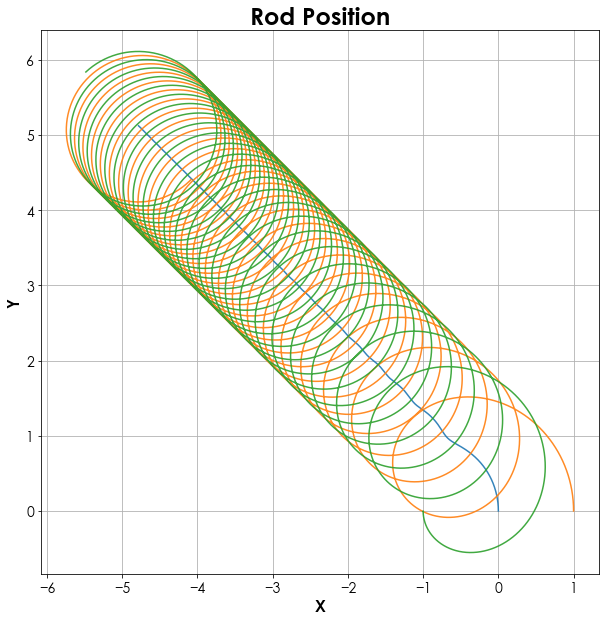

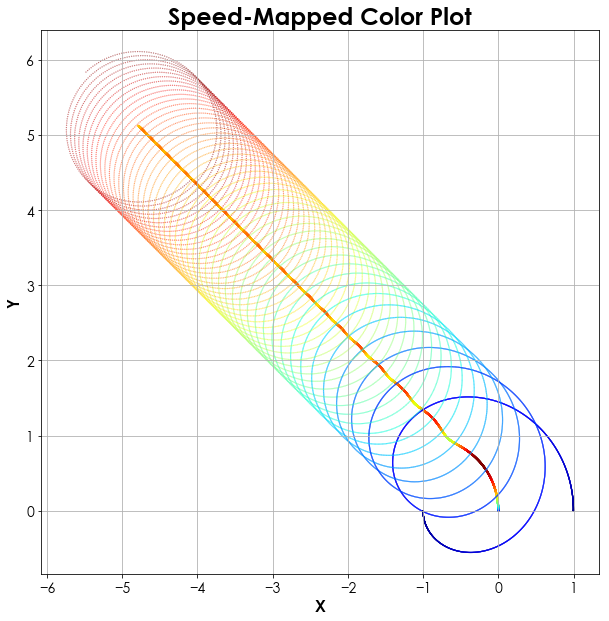

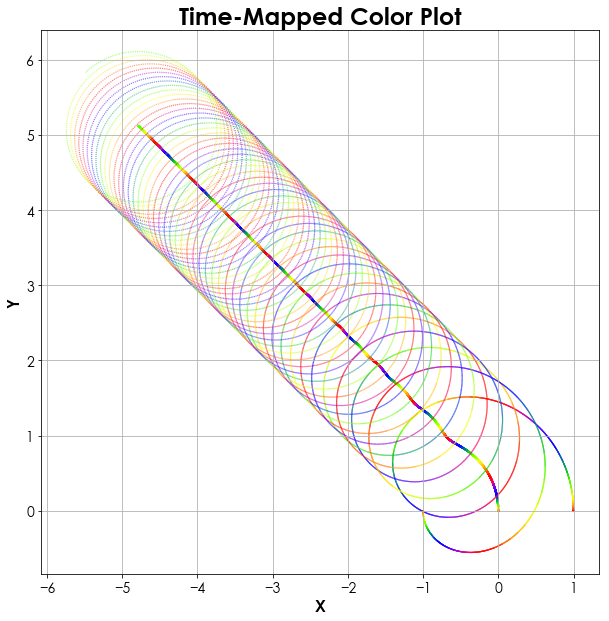

In [36]:
##### ----- Rod with Standard Parameters ----- #####

s, A, B = set_params(1, 1, 1)   
t, v, v_x, v_y, v_edge_1, v_edge_2, x, y, x_edge_1, y_edge_1, y_edge_2, x_edge_2, y_edge_2 = calculate_eom()
diagnostic_plots()
speed_color_plot()
time_color_plot()

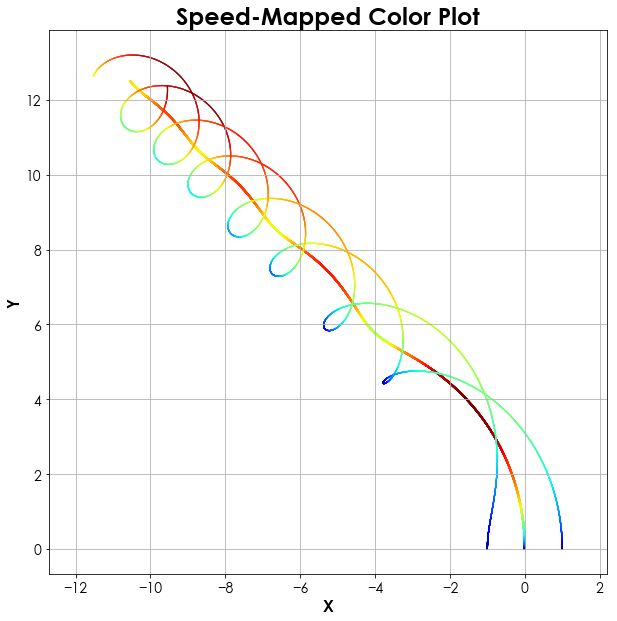

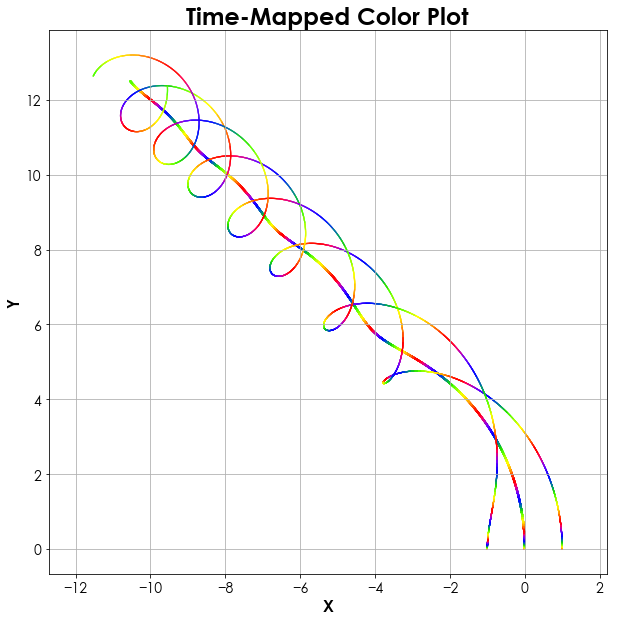

In [45]:
##### ----- Object with Larger Moment of Inertia ----- #####

s, A, B = set_params(1, 1, 1, 2)   
t, v, v_x, v_y, v_edge_1, v_edge_2, x, y, x_edge_1, y_edge_1, y_edge_2, x_edge_2, y_edge_2 = calculate_eom()
# diagnostic_plots()
speed_color_plot()
time_color_plot()

In [22]:
print([min(v), max(v)])
print([min(v_edge_1), max(v_edge_1)])
print([min(v_edge_2), max(v_edge_2)])

[0.001, 2.3790675594309665]
[0.001, 6.2149675200551426]
[0.001, 6.5533744502211713]
